In [1]:
import time
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
random.seed(9001)
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None


In [3]:
def loadingdata(path):
    # import dataset
    df = pd.read_csv(path)
    print (df.isnull().sum())
    print ('Number of Original Dataset : %d' % (df.shape[0]))
    print ('Number of Drop NaN : %d' % (df.dropna(axis = 0).shape[0]))
    return df


1. "start time and duration" of particular flow
2. "source and destination port" used in specifying the services offered on local or remote hosts
3. "source and destination ip address" used for packet to traverse in the network
4. "protocol" that specifies interaction between communicating entities
5. "ToS" field used in assigning priority for IP packet
6. "total bytes and total packets" transmitted during particular flow 
##### These features are not sufficient to discriminate botnet traffic from normal traffic. So features like average byte rate, average packet rate, ping bytes, time comparison, malicious ports which will help in determining the botnet traffic are identified and extracted. 


1. Start time:此特性定義流的開始時間。它是網絡流場的基本特徵之一。開始時間轉換為分類的數值。將時間格式轉換為數值的公式是小時* 3600 +分鐘* 60 +秒，它與結束時間比較表明流量是惡意的。

2. End time:流的結束時間描繪流完成時間。將結束時間與惡意流訓示的開始時間進行比較。它是利用公式 t_e = t_s + dur.
3. Duration:流的持續時間表示完成特定流所需的總時間。流的持續時間被用來計算平均分組速率和平均位元組速率。  
4. Protocol:協定是一組特殊的規則，在通信連接中，端點在通信時使用。協定指定通信實體之間的互動。使用的協定有不同的類型，它們是TCP、UDP、ICMP、SMTP等。
5. Source IP Address:The IP Address is used to uniquely identify the desired host to contact. It is also one of the basic features of net flow fields. The source IP address is the IP address of the computer and or website that are currently visiting, or using. The source IP address is converted to decimal format for further processing. It is computed as follows 10.0.2.112 is converted to 167772784 
6. port:允許我們識別我們的數據或請求必須發送到的服務或應用程序。它們可用於獲取針對攻擊目標的遠程系統的資訊。埠號80，53，25被標記為具有不同僵屍網路攻擊的惡意流，它們是HTTP建立的僵屍網路、垃圾郵件僵屍網路和基於DNS伺服器的僵屍網路。16-bit to 10-bit processing.
7. dir:訓示指定數據是否沿兩個方向或僅一個方向移動。方向也指定路徑，流量將從源到目的地通過互聯網絡。大多數流是雙向的，可以用雙面箭頭表示，單向流用單邊箭頭表示。大多數垃圾郵件僵屍網路使用單向流。
8. States:表示網路流的狀態有不同的類型，它們是SYN、RST、CON、ACK、FIN.。 There are different types of states that represent the network flow they are SYN, RST, CON, ACK, FIN. In the SYN state client sends a SYN message which contains the server's port and the client's Initial Sequence Number to the server. The server sends back its own SYN and ACK.The Client sends an ACK. Final state is the state is a now a half-closed connection. The client no longer sends data, but is still able to receive data from the server. Upon receiving this FIN, the server enters a close state. CON is the connection state in when once the connection is established it is in CON state. The RST state is the connection reset state in which the host refuses a connection. Too many SYN state is received means sender is infected. Too many RST state is received means receiver is infected.
9. Tos:ToS is defined as type of service。它是一種將優先順序分配給每個IP包的機制，以及請求特定處理的機制，如高輸送量、高可靠性或低延遲。通常情况下欄位將為0。
10. TotPkts:Total packets特徵被定義為在特定流中傳輸的數据包的個數。它存儲在特定時間段或流期間傳輸的數据包的數量。  
11. TotBytes:Total Bytes内容指定用戶端根據請求發送的總位元組數。它的總位元組大小是衡量網絡量測的一個重要名額。

In [8]:
def preprocessing(df, con_normal):
    print ("number of begin features :", df.shape)
    
    # labeling botnet
    bot = df[~con_normal]
    nonbot = df[con_normal]
    bot["label"] = 1
    nonbot["label"] = 0
    df = pd.concat([bot, nonbot])
    df = df.drop(["Label"], axis=1).sort_values(by = "StartTime", axis = 0, ascending = True).reset_index(drop=True)
    
    print('Number of Botnet : %d' % (bot.shape[0]))
    print('Number of Normal : %d' % (nonbot.shape[0]))
    # StartTime & EndTime
    con0 = pd.DataFrame(df.StartTime.str.split('/', 3).tolist(), columns = ['year', 'month', 'a'])
    con1 = pd.DataFrame(con0.a.str.split(':', 3).tolist(), columns = ['b', 'mins', 'sec'])
    con2 = pd.DataFrame(con1.b.str.split(' ', 2).tolist(), columns = ['day', 'hr'])
    con2.hr = pd.to_numeric(con2.hr, errors='coerce')
    con1.mins = pd.to_numeric(con1.mins, errors='coerce')
    con1.sec = pd.to_numeric(con1.sec, errors='coerce')
    df["StartTime"] = con2.hr*3600 + con1.mins*60 + con1.sec
    df["endtime"] = df.StartTime + df.Dur
    
    # missing value
    df.Sport = df.Sport.fillna(value=df[~(df['Sport'].isnull())].Sport.mode()[0])
    df.Dport = df.Dport.fillna(value=df[~(df['Dport'].isnull())].Dport.mode()[0])
    df.State = df.State.fillna(value=df[~(df['State'].isnull())].State.mode()[0])
    df.sTos = df.sTos.fillna(value=df[~(df['sTos'].isnull())].sTos.mode()[0])
    df.dTos = df.dTos.fillna(value=df[~(df['dTos'].isnull())].dTos.mode()[0])

    # select row of Sport is 16-bit
    con0 = pd.DataFrame(df.Sport.str.split('x',2).tolist(), columns = ['Sport','y'])
    Sport_16 = df.iloc[con0[~(con0['y'].isnull())].index,:].reset_index(drop=True)
    # 16 to 10
    Sport_16_ = Sport_16[["Sport"]]
    a=[]
    for i in range(Sport_16_.shape[0]):
        x = int(Sport_16_.iloc[i,].Sport, 16)
        a.append(x)
    Sport_10 = pd.DataFrame(a, columns=["Sport_10"])
    Sport_16["Sport"] = Sport_10.Sport_10
    df = pd.concat([df.iloc[con0[(con0['y'].isnull())].index,:], Sport_16], axis=0).reset_index(drop=True)
    del Sport_16
    del Sport_16_
    
    # select row of Dport is 16-bit
    con0 = pd.DataFrame(df.Dport.str.split('x',2).tolist(), columns = ['Sport','y'])
    Dport_16 = df.iloc[con0[~(con0['y'].isnull())].index,:].reset_index(drop=True)
    # 16 to 10
    Dport_16_ = Dport_16[["Dport"]]
    a=[]
    for i in range(Dport_16_.shape[0]):
        x = int(Dport_16_.iloc[i,].Dport, 16)
        a.append(x)
    Dport_10 = pd.DataFrame(a, columns=["Dport_10"])
    Dport_16["Dport"] = Dport_10.Dport_10
    df = pd.concat([df.iloc[con0[(con0['y'].isnull())].index,:], Dport_16], axis=0).reset_index(drop=True)
    del Dport_16
    del Dport_16_
    
    # aveByteRate & avePktsRate
    df.TotBytes = pd.to_numeric(df.TotBytes, errors='coerce')
    df.TotPkts = pd.to_numeric(df.TotPkts, errors='coerce')
    df.Dur = pd.to_numeric(df.Dur, errors='coerce')
    df["aveByteRate"] = df.TotBytes/(df.Dur + 1.000000e-07)
    df["avePktsRate"] = df.TotPkts/(df.Dur+ 1.000000e-07)
    
    # PingBytes
    small = df[(df.TotPkts <= 65535)]
    big = df[(df.TotPkts > 65535)]
    small["PingBytes"] = 0
    big["PingBytes"] = 1
    df = pd.concat([small, big], axis=0).reset_index(drop=True)
    del small
    del big
    df = df.sort_values(by=["StartTime"]).reset_index(drop=True)
    print ("number of end fearures :", df.shape)
    return df

In [9]:
# loading dataset
path_10 = "capture20110810.binetflow.txt"
df_10 = loadingdata(path_10)

# preprocessing
con_normal = (df_10.SrcAddr != "147.32.84.165") 
df_10 = preprocessing(df_10, con_normal)

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport          9379
Dir               0
DstAddr           0
Dport          4390
State             1
sTos          10590
dTos         195190
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64
Number of Original Dataset : 2824636
Number of Drop NaN : 2619340
number of begin features : (2824636, 15)
Number of Botnet : 40961
Number of Normal : 2783675
number of end fearures : (2824636, 19)


In [6]:
# ip preprocessing, but out of memory
#con0 = pd.DataFrame(df_10.SrcAddr.str.split('.', 4).tolist(), columns = ['a', 'b', 'c', 'd'])
#con0.a = pd.to_numeric(con0.a, errors='coerce')
#con0.b = pd.to_numeric(con0.b, errors='coerce')
#con0.c = pd.to_numeric(con0.c, errors='coerce')
#con0.d = pd.to_numeric(con0.d, errors='coerce')

#df_10["SrcAddr_new"] = con0.a*256*256*256 + con0.b*256*256 + con0*256 + con0.d
#con0.head()

In [14]:
def X_preprocessing(df):
    # remove in&out IP and label
    df = df.drop(["label", "SrcAddr", "DstAddr"], axis = 1)
    # category 
    df.Proto = df.Proto.astype("category").cat.codes
    df.State = df.State.astype("category").cat.codes
    df.Dir = df.Dir.astype("category").cat.codes
    # StandardScaler
    sc = StandardScaler(copy=True, with_mean=True, with_std=True)
    Z = sc.fit_transform(df)
    return df

# split
def split(X, y):
    X_train = X[X.index % 5 != 2]
    X_val = X[X.index % 5 == 2]
    y_train = y[y.index % 5 != 2]
    y_val = y[y.index % 5 == 2]

    cw0 = pd.DataFrame(y, columns=["label"]).label.value_counts()[0]/y.shape[0]
    cw1 = pd.DataFrame(y, columns=["label"]).label.value_counts()[1]/y.shape[0]
    
    print ("size of train :", X_train.shape[0])
    print ("size of val   :", X_val.shape[0])
    print ("------------------------------------")
    print ("class_weight :", cw0, cw1)
    return X_train, X_val, y_train, y_val, cw0, cw1

# Evaluation
def evaluation(model, X_val, y_val):
    print (str(model))
    predicted = model.predict(X_val)
    
    fpr, tpr, _ = roc_curve(y_val, (model.predict_proba(X_val)[:, 1]))
    auc_ = auc(fpr, tpr)
    cm = confusion_matrix(y_val, predicted, labels = None, sample_weight = None)

    np.set_printoptions(precision=2)
    class_names = ["normal", "botnet"]

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names,
                          title = 'Confusion matrix, without normalization')
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names, normalize = True,
                          title = 'Normalized confusion matrix')
    print("------------------------------------")
    print("Baseline    : %.6f" % (1 - sum(y_val)/y_val.shape[0]))
    print("Accuracy    : %f" % model.score(X_val, y_val))  #checking the accuracy
    print("Precision   : %f" % precision_score(y_val, predicted))
    print("Recall      : %f" % recall_score(y_val, predicted))
    print("F1-Score    : %f" % f1_score(y_val, predicted))
    print("AUC         : %f" % auc_)
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [11]:
X = X_preprocessing(df_10)
X_train, X_val, y_train, y_val, cw0, cw1 = split(X, df_10.label)

size of train : 2259709
size of val   : 564927
------------------------------------
class_weight : 0.985498662483 0.0145013375175


In [9]:
#rfr = RandomForestClassifier(class_weight = {1: cw1, 0: cw0})

#param_grid = {'n_estimators': [20, 100, 300], 'max_features': [3, 4, 5], 'criterion':['entropy', 'gini']}
#model = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=3, verbose=5, n_jobs=100)
#model.fit(X_val, y_val)


In [12]:
# Training
t0 = time.time()

#clf = model.best_estimator_
clf = RandomForestClassifier(n_estimators = 20, class_weight = {1: cw1, 0: cw0})

clf.fit(X_train, y_train)

t1 = time.time()
print("It cost %f sec" % (t1 - t0))

It cost 107.957643 sec


RandomForestClassifier(bootstrap=True,
            class_weight={1: 0.014501337517471277, 0: 0.98549866248252871},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Confusion matrix, without normalization
[[556741      6]
 [   103   8077]]
Normalized confusion matrix
[[  1.00e+00   1.08e-05]
 [  1.26e-02   9.87e-01]]
------------------------------------
Baseline    : 0.985520
Accuracy    : 0.999807
Precision   : 0.999258
Recall      : 0.987408
F1-Score    : 0.993298
AUC         : 0.999555


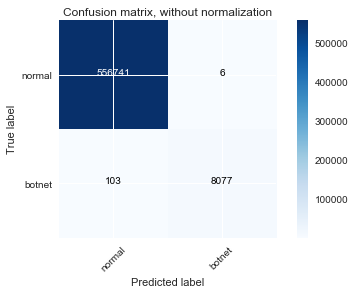

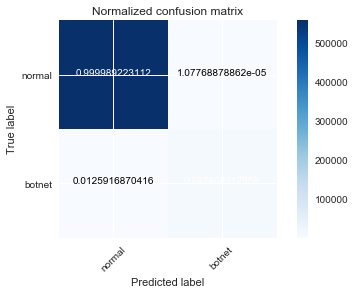

In [15]:
# evaluation
evaluation(clf, X_val, y_val)

### xgboost

[0]	train-logloss:0.598422
[10]	train-logloss:0.178342
[20]	train-logloss:0.062901
[30]	train-logloss:0.024063
[40]	train-logloss:0.009881
[50]	train-logloss:0.004618
[60]	train-logloss:0.00259
[70]	train-logloss:0.001778


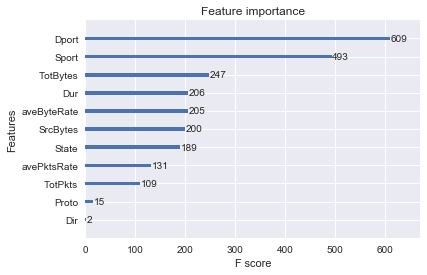

In [16]:
# xgboost
X.Sport = X.Sport.astype(int, copy=True, errors='raise')
X.Dport = X.Dport.astype(int, copy=True, errors='raise')
d_train = xgboost.DMatrix(X.drop(["StartTime", "endtime"], axis=1), df_10.label)

xgb_params = {
    "objective"        : "reg:logistic",
    "eval_metric"      : "logloss",
    "eta"              : 0.1,
    "max_depth"        : 8,
    "min_child_weight" : 10,
    "gamma"            : 0.70,
    "subsample"        : 0.76,
    "colsample_bytree" : 0.95,
    "alpha"            : 2e-05,
    "lambda"           : 10
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params = xgb_params,
                    dtrain = d_train,
                    num_boost_round = 80,
                    evals = watchlist,
                    verbose_eval = 10)

xgboost.plot_importance(bst)
plt.show()

In [17]:
# Training on all dataset
t0 = time.time()

clf.fit(X, df_10.label)

t1 = time.time()
print("It cost %f sec" % (t1 - t0))


It cost 143.499579 sec


### test on other dataset

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport          3993
Dir               0
DstAddr           0
Dport          2973
State             0
sTos           4324
dTos         269835
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64
Number of Original Dataset : 1808122
Number of Drop NaN : 1534307
number of begin features : (1808122, 15)
Number of Botnet : 20941
Number of Normal : 1787181
number of end fearures : (1808122, 19)
RandomForestClassifier(bootstrap=True,
            class_weight={1: 0.014501337517471277, 0: 0.98549866248252871},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Confusion matrix, without normalizati

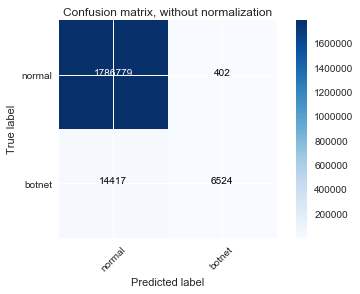

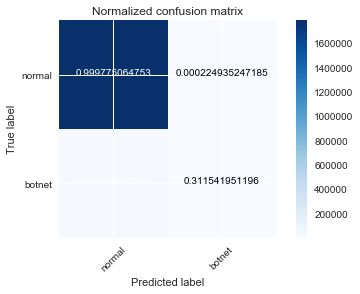

In [18]:
# loading dataset
path_11 = "capture20110811.binetflow.txt"
df_11 = loadingdata(path_11)

# preprocessing
con_normal = (df_11.SrcAddr != "147.32.84.165") 
df_11 = preprocessing(df_11, con_normal)

# test
X_ = X_preprocessing(df_11)
y_ = df_11.label
evaluation(clf, X_, y_)


Confusion matrix, without normalization
[[1786426     755]
 [  14068    6873]]
Normalized confusion matrix
[[  1.00e+00   4.22e-04]
 [  6.72e-01   3.28e-01]]
------------------------------------
Baseline    : 0.988418
Precision   : 0.901023
Recall      : 0.328208
F1-Score    : 0.481151
AUC         : 0.663893


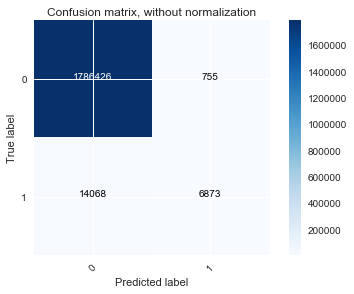

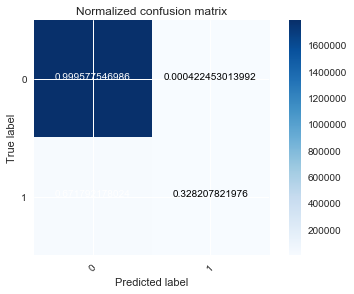

In [19]:
### xgboost

X_.Sport = X_.Sport.astype(int, copy=True, errors='raise')
X_.Dport = X_.Dport.astype(int, copy=True, errors='raise')
d_test = xgboost.DMatrix(X_.drop(["StartTime", "endtime"], axis=1))

predicted = (bst.predict(d_test) > 0.21).astype(int)
y_val = y_

fpr, tpr, _ = roc_curve(y_val, predicted)
auc_ = auc(fpr, tpr)
cm = confusion_matrix(y_val, predicted, labels = None, sample_weight = None)

np.set_printoptions(precision=2)
class_names = ["0", "1"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names,
                      title = 'Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True,
                      title = 'Normalized confusion matrix')
print("------------------------------------")
print("Baseline    : %.6f" % (1 - sum(y_val)/y_val.shape[0]))
print("Precision   : %f" % precision_score(y_val, predicted))
print("Recall      : %f" % recall_score(y_val, predicted))
print("F1-Score    : %f" % f1_score(y_val, predicted))
print("AUC         : %f" % auc_)
plt.show()


StartTime        0
Dur              0
Proto            0
SrcAddr          0
Sport         1812
Dir              0
DstAddr          0
Dport          837
State            0
sTos          2059
dTos         28267
TotPkts          0
TotBytes         0
SrcBytes         0
Label            0
dtype: int64
Number of Original Dataset : 325471
Number of Drop NaN : 295270
number of begin features : (325471, 15)
Number of Botnet : 2143
Number of Normal : 323328
number of end fearures : (325471, 19)
RandomForestClassifier(bootstrap=True,
            class_weight={1: 0.014501337517471277, 0: 0.98549866248252871},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Confusion matrix, without normalization
[[323282     46]
 

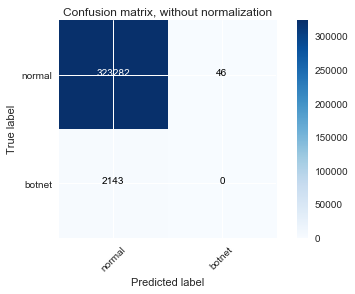

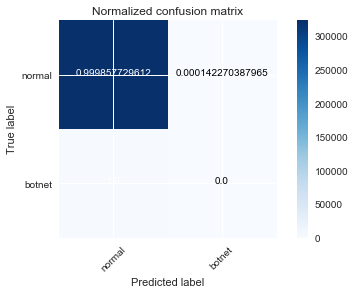

In [20]:
# loading dataset
path_19 = "capture20110819.binetflow.txt"
df_19 = loadingdata(path_19)

# preprocessing
con_normal = (df_19.SrcAddr != "147.32.84.165")&(df_19.SrcAddr != "147.32.84.191")&(df_19.SrcAddr != "147.32.84.192") 
df_19 = preprocessing(df_19, con_normal)

# test
X_ = X_preprocessing(df_19)
y_ = df_19.label
evaluation(clf, X_, y_)


Confusion matrix, without normalization
[[323261     67]
 [  2077     66]]
Normalized confusion matrix
[[  1.00e+00   2.07e-04]
 [  9.69e-01   3.08e-02]]
------------------------------------
Baseline    : 0.993416
Precision   : 0.496241
Recall      : 0.030798
F1-Score    : 0.057996
AUC         : 0.515295


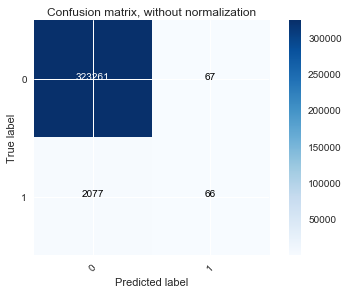

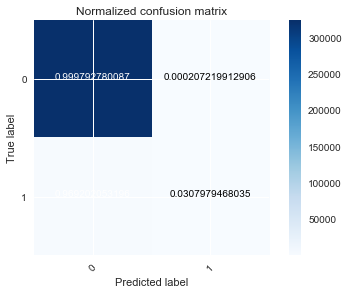

In [21]:
### xgboost

X_.Sport = X_.Sport.astype(int, copy=True, errors='raise')
X_.Dport = X_.Dport.astype(int, copy=True, errors='raise')
d_test = xgboost.DMatrix(X_.drop(["StartTime", "endtime"], axis=1))

predicted = (bst.predict(d_test) > 0.21).astype(int)
y_val = y_

fpr, tpr, _ = roc_curve(y_val, predicted)
auc_ = auc(fpr, tpr)
cm = confusion_matrix(y_val, predicted, labels = None, sample_weight = None)

np.set_printoptions(precision=2)
class_names = ["0", "1"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names,
                      title = 'Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True,
                      title = 'Normalized confusion matrix')
print("------------------------------------")
print("Baseline    : %.6f" % (1 - sum(y_val)/y_val.shape[0]))
print("Precision   : %f" % precision_score(y_val, predicted))
print("Recall      : %f" % recall_score(y_val, predicted))
print("F1-Score    : %f" % f1_score(y_val, predicted))
print("AUC         : %f" % auc_)
plt.show()
